In [1]:
import pandas as pd
import numpy as np

In [2]:
!ls

MOD04_3K.A2015091.1750.006.2015092021418.hdf
MOD04_L2.A2015062.1645.006.2015063024748.hdf
MOD04_L2.A2015085.1650.006.2015086020817.hdf
MODIS_Data
MODIS_fileList.txt
MYD04_3K.A2018114.0710.006.2018114193745.hdf
MYD04_L2.A2011165.1635.006.2014083125006.hdf
MYD04_L2.A2011165.1805.006.2014083124239.hdf
MYD04_L2.A2011165.1810.006.2014083124801.hdf
MYD04_L2.A2017332.0820.006.2017332194745.hdf
MYD04_L2.A2017332.0820.006.2017332194745.png
MYD04_L2.A2017332.0820.006.2017332194745.txt
Small-MODIS_fileList.txt
Untitled.ipynb
Untitled1.ipynb
Untitled2.ipynb
Untitled3.ipynb
Untitled4.ipynb
airquality.html
aq-pm2.5-2017.ipynb
download_aq_data.ipynb
download_modis_files.ipynb
ftp.ipynb
laads-data-download.py
map.ipynb
open-aq.ipynb
openaq-api-eda.ipynb
pm25-modis.ipynb
pm25hourly.png
pm25timeseries.png
read_and_map_mod_aerosol.py


In [3]:
!cat read_and_map_mod_aerosol.py

print('\nAll valid files have been processed.')

In [4]:
from pyhdf import SD
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import sys

In [5]:
#This uses the file "fileList.txt", containing the list of files, in order to read the files
try:
    fileList=open('Small-MODIS_fileList.txt','r')
except:
    print('Did not find a text file containing file names (perhaps name does not match)')
    sys.exit()

In [6]:
import time, calendar
#loops through all files listed in the text file
for FILE_NAME in fileList:
    FILE_NAME=FILE_NAME.strip()
    user_input=input('\nWould you like to process\n' + FILE_NAME + '\n\n(Y/N)')
    if(user_input == 'N' or user_input == 'n'):
        continue
    else:
        if '3K' in FILE_NAME: #then this is a 3km MODIS file
            print('This is a 3km MODIS file. Saving... ')
            #saves all the SDS to be outputted to ASCII in a dictionary
            dataFields=dict([(1,'Optical_Depth_Land_And_Ocean'),(2,'Image_Optical_Depth_Land_And_Ocean'),(3,'Land_sea_Flag'),(4,'Land_Ocean_Quality_Flag')])
     # The name of the SDS to read
        elif 'L2' in FILE_NAME: #Same as above but for 10km MODIS file
            print('This is a 10km MODIS file. Saving... ')
            dataFields=dict([(1,'Deep_Blue_Aerosol_Optical_Depth_550_Land'),(2,'AOD_550_Dark_Target_Deep_Blue_Combined'),
                             (3,'AOD_550_Dark_Target_Deep_Blue_Combined_QA_Flag'), (4,'Aerosol_Cloud_Fraction_Land'),
                            (5, 'Image_Optical_Depth_Land_And_Ocean')])
        else:
            print('The file :',FILE_NAME, ' is not a valid MODIS file (or is named incorrectly). \n')
            continue
        try:
            # open the hdf file for reading
            hdf=SD.SD(FILE_NAME)
        except:
            print('Unable to open file: \n' + FILE_NAME + '\n Skipping...')
            continue

        # Get lat and lon info
        lat = hdf.select('Latitude')
        lat=(lat.get()).ravel()
        latitude = np.array(lat[:])
        lon = hdf.select('Longitude')
        lon=(lon.get()).ravel()
        longitude = np.array(lon[:])

        #Get the scan start time from the hdf file. This is in number of seconds since Jan 1, 1993
        scan_time=hdf.select('Scan_Start_Time')
        scan_time=(scan_time.get()).ravel()
        scan_time=scan_time[:]
        #get the date info from scan_time
        year=np.zeros(scan_time.shape[0])
        month=np.zeros(scan_time.shape[0])
        day=np.zeros(scan_time.shape[0])
        hour=np.zeros(scan_time.shape[0])
        min=np.zeros(scan_time.shape[0])
        sec=np.zeros(scan_time.shape[0])
        #Saves date info for each pixel to be saved later
        for i in range(scan_time.shape[0]):
            temp=time.gmtime(scan_time[i-1]+calendar.timegm(time.strptime('Dec 31, 1992 @ 23:59:59 UTC', '%b %d, %Y @ %H:%M:%S UTC')))
            year[i-1]=temp[0]
            month[i-1]=temp[1]
            day[i-1]=temp[2]
            hour[i-1]=temp[3]
            min[i-1]=temp[4]
            sec[i-1]=temp[5]

        #Begin saving to an output array
        end=8+len(dataFields)#this is the number of columns needed (based on number of SDS read)
        output=np.array(np.zeros((year.shape[0],end)))
        output[0:,0]=year[:]
        output[0:,1]=month[:]
        output[0:,2]=day[:]
        output[0:,3]=hour[:]
        output[0:,4]=min[:]
        output[0:,5]=sec[:]
        output[0:,6]=latitude[:]
        output[0:,7]=longitude[:]
        #list for the column titles
        tempOutput=[]
        tempOutput.append('Year')
        tempOutput.append('Month')
        tempOutput.append('Day')
        tempOutput.append('Hour')
        tempOutput.append('Minute')
        tempOutput.append('Second')
        tempOutput.append('Latitude')
        tempOutput.append('Longitude')
        #This for loop saves all of the SDS in the dictionary at the top (dependent on file type) to the array (with titles)
        for i in range(8,end):
            SDS_NAME=dataFields[(i-7)] # The name of the sds to read
            #get current SDS data, or exit program if the SDS is not found in the file
            try:
                sds=hdf.select(SDS_NAME)
            except:
                print('Sorry, your MODIS hdf file does not contain the SDS:',SDS_NAME,'. Please try again with the correct file type.')
                continue
            #get scale factor for current SDS
            attributes=sds.attributes()
            scale_factor=attributes['scale_factor']
            fillvalue=attributes['_FillValue']
            #get SDS data as a vector
            data=(sds.get()).ravel()
            data=np.array(data[:])
            #The next few lines change fillvalue to NaN so that we can multiply valid values by the scale factor, then back to fill values
            data=data.astype(float)
            data[data==float(fillvalue)]=np.nan
            data=data*scale_factor
            data[np.isnan(data)]=fillvalue
            #the SDS and SDS name are saved to arrays which will be written to the .txt file
            output[0:,i]=data
            tempOutput.append(SDS_NAME)
        #changes list to an array so it can be stacked	
        tempOutput=np.asarray(tempOutput)
        #This stacks the titles on top of the data
        output=np.row_stack((tempOutput,output))
        #save the new array to a text file, which is the name of the HDF4 file .txt instead of .hdf
        np.savetxt('{0}.txt'.format(FILE_NAME[:-4]),output,fmt='%s',delimiter=',')
    print('\nAll valid files have been saved successfully.')


Would you like to process
MYD04_L2.A2017332.0820.006.2017332194745.hdf

(Y/N)y
This is a 10km MODIS file. Saving... 

All valid files have been saved successfully.


In [7]:
df = pd.read_csv("MYD04_L2.A2017332.0820.006.2017332194745.txt")



In [14]:
%matplotlib inline

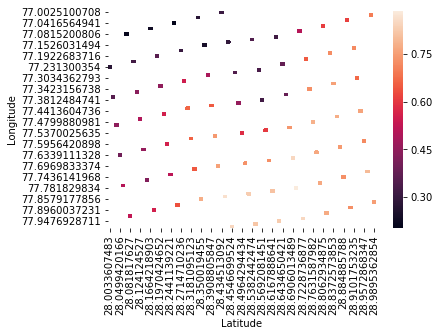

In [17]:
q = df[(df.Latitude>28)&(df.Latitude<29)&(df.Longitude>77)&(df.Longitude<78)]
import seaborn as sns
sns.heatmap(q.pivot_table(values='Deep_Blue_Aerosol_Optical_Depth_550_Land',index='Longitude', columns=['Latitude']))

In [8]:
df.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Latitude',
       'Longitude', 'Deep_Blue_Aerosol_Optical_Depth_550_Land',
       'AOD_550_Dark_Target_Deep_Blue_Combined',
       'AOD_550_Dark_Target_Deep_Blue_Combined_QA_Flag',
       'Aerosol_Cloud_Fraction_Land', 'Image_Optical_Depth_Land_And_Ocean'],
      dtype='object')

In [30]:
points = {
    'Pusa': {'Latitude':28.637672, 'Longitude':77.157144},
    'RKP':{'Latitude':28.566008, 'Longitude':77.176743}
}

In [39]:
(points['Pusa']['Latitude']-df.Latitude).abs().sort_values().head()

19176    0.000069
21701    0.000579
21562    0.000654
20579    0.001408
22939    0.001743
Name: Latitude, dtype: float64

In [41]:
(points['Pusa']['Longitude']-df.Longitude).abs().sort_values().head()

8554     0.000304
3162     0.000327
10711    0.000757
601      0.001504
12194    0.001764
Name: Longitude, dtype: float64

In [49]:
df.iloc[((points['RKP']['Latitude']-df.Latitude).abs() + (points['RKP']['Longitude']-df.Longitude).abs()).sort_values().index].head(1)

,Year,Month,Day,Hour,Minute,Second,Latitude,Longitude,Deep_Blue_Aerosol_Optical_Depth_550_Land,AOD_550_Dark_Target_Deep_Blue_Combined,AOD_550_Dark_Target_Deep_Blue_Combined_QA_Flag,Aerosol_Cloud_Fraction_Land,Image_Optical_Depth_Land_And_Ocean
19879,2017.0,11.0,28.0,8.0,23.0,47.0,28.553648,77.246223,0.331,0.424,3.0,0.122,0.517


In [46]:
df.iloc[((points['Pusa']['Latitude']-df.Latitude).abs() + (points['Pusa']['Longitude']-df.Longitude).abs()).sort_values().index]

,Year,Month,Day,Hour,Minute,Second,Latitude,Longitude,Deep_Blue_Aerosol_Optical_Depth_550_Land,AOD_550_Dark_Target_Deep_Blue_Combined,AOD_550_Dark_Target_Deep_Blue_Combined_QA_Flag,Aerosol_Cloud_Fraction_Land,Image_Optical_Depth_Land_And_Ocean
20015,2017.0,11.0,28.0,8.0,23.0,48.0,28.628059,77.093338,0.315,0.499,3.0,0.092,0.499
20014,2017.0,11.0,28.0,8.0,23.0,48.0,28.643465,77.225883,0.378,0.499,3.0,0.092,0.499
19880,2017.0,11.0,28.0,8.0,23.0,47.0,28.538244,77.113693,0.348,0.426,3.0,0.267,0.426
20149,2017.0,11.0,28.0,8.0,23.0,50.0,28.731918,77.207245,0.652,-9999.000,0.0,0.059,0.773
20150,2017.0,11.0,28.0,8.0,23.0,50.0,28.716511,77.074524,0.510,0.626,3.0,0.052,0.626
19879,2017.0,11.0,28.0,8.0,23.0,47.0,28.553648,77.246223,0.331,0.424,3.0,0.122,0.517
19745,2017.0,11.0,28.0,8.0,23.0,45.0,28.449738,77.132271,0.291,0.316,3.0,0.140,0.316
20284,2017.0,11.0,28.0,8.0,23.0,51.0,28.821709,77.186874,0.727,0.731,3.0,0.077,0.731
20016,2017.0,11.0,28.0,8.0,23.0,48.0,28.612799,76.963089,0.272,0.385,3.0,0.062,0.385
20013,2017.0,11.0,28.0,8.0,23.0,48.0,28.659029,77.360962,0.384,-9999.000,0.0,0.090,0.633


In [36]:
df.iloc[((points['Pusa']['Latitude']-df.Latitude).abs()) + ((points['Pusa']['Longitude']-df.Longitude).abs()).sort_values().index[:10]]

ValueError: cannot evaluate a numeric op with unequal lengths

In [28]:
(df.Latitude - 28.564).abs().sort_values()
df.iloc[(77.20050049-df.Longitude).abs().sort_values().index[:10]]

,Year,Month,Day,Hour,Minute,Second,Latitude,Longitude,Deep_Blue_Aerosol_Optical_Depth_550_Land,AOD_550_Dark_Target_Deep_Blue_Combined,AOD_550_Dark_Target_Deep_Blue_Combined_QA_Flag,Aerosol_Cloud_Fraction_Land,Image_Optical_Depth_Land_And_Ocean
15834,2017.0,11.0,28.0,8.0,23.0,2.0,25.803387,77.200348,0.259,0.061,3.0,0.000,0.061
2218,2017.0,11.0,28.0,8.0,20.0,33.0,16.530060,77.200256,0.315,0.423,3.0,0.054,0.423
8958,2017.0,11.0,28.0,8.0,21.0,47.0,21.126774,77.201111,0.136,0.252,3.0,0.000,0.252
14216,2017.0,11.0,28.0,8.0,22.0,45.0,24.703938,77.199379,0.137,0.139,3.0,0.000,0.139
25004,2017.0,11.0,28.0,8.0,24.0,43.0,32.017979,77.201714,-9999.000,-9999.000,0.0,0.892,-9999.000
18396,2017.0,11.0,28.0,8.0,23.0,30.0,27.542992,77.198975,0.159,0.151,3.0,0.000,0.151
15025,2017.0,11.0,28.0,8.0,22.0,53.0,25.253679,77.198944,0.162,0.017,3.0,0.009,0.017
13407,2017.0,11.0,28.0,8.0,22.0,36.0,24.154341,77.202820,0.172,0.169,3.0,0.000,0.169
16643,2017.0,11.0,28.0,8.0,23.0,11.0,26.353231,77.203621,0.047,0.047,3.0,0.000,0.114
8284,2017.0,11.0,28.0,8.0,21.0,40.0,20.666260,77.196823,0.240,0.223,3.0,0.000,0.223


In [8]:
df.iloc[((77.20050049-df.Longitude).abs() + (28.63409996-df.Latitude).abs()).argmin()]

Year                                              2017.000000
Month                                               11.000000
Day                                                 28.000000
Hour                                                 8.000000
Minute                                              23.000000
Second                                              48.000000
Latitude                                            28.643465
Longitude                                           77.225883
Deep_Blue_Aerosol_Optical_Depth_550_Land             0.378000
AOD_550_Dark_Target_Deep_Blue_Combined               0.499000
AOD_550_Dark_Target_Deep_Blue_Combined_QA_Flag       3.000000
Aerosol_Cloud_Fraction_Land                          0.092000
Image_Optical_Depth_Land_And_Ocean                   0.499000
Name: 20014, dtype: float64

In [9]:
df.iloc[((77.17440033-df.Longitude).abs() + (28.56480026-df.Latitude).abs()).argmin()]

Year                                              2017.000000
Month                                               11.000000
Day                                                 28.000000
Hour                                                 8.000000
Minute                                              23.000000
Second                                              47.000000
Latitude                                            28.553648
Longitude                                           77.246223
Deep_Blue_Aerosol_Optical_Depth_550_Land             0.331000
AOD_550_Dark_Target_Deep_Blue_Combined               0.424000
AOD_550_Dark_Target_Deep_Blue_Combined_QA_Flag       3.000000
Aerosol_Cloud_Fraction_Land                          0.122000
Image_Optical_Depth_Land_And_Ocean                   0.517000
Name: 19879, dtype: float64

In [10]:
df.iloc[((77.17440033-df.Longitude).abs() + (28.56480026-df.Latitude).abs()).argmin()]

Year                                              2017.000000
Month                                               11.000000
Day                                                 28.000000
Hour                                                 8.000000
Minute                                              23.000000
Second                                              47.000000
Latitude                                            28.553648
Longitude                                           77.246223
Deep_Blue_Aerosol_Optical_Depth_550_Land             0.331000
AOD_550_Dark_Target_Deep_Blue_Combined               0.424000
AOD_550_Dark_Target_Deep_Blue_Combined_QA_Flag       3.000000
Aerosol_Cloud_Fraction_Land                          0.122000
Image_Optical_Depth_Land_And_Ocean                   0.517000
Name: 19879, dtype: float64

In [6]:
%matplotlib inline

In [7]:
q = df[(df.Latitude>28)&(df.Latitude<29)&(df.Longitude>77)&(df.Longitude<78)]

NameError: name 'df' is not defined

In [8]:
import seaborn as sns
sns.heatmap(q.pivot_table(values='Image_Optical_Depth_Land_And_Ocean', index='Latitude', columns='Longitude'))

NameError: name 'q' is not defined

In [6]:
#loops through all files listed in the text file
for FILE_NAME in fileList:
    FILE_NAME=FILE_NAME.strip()
    user_input=input('\nWould you like to process\n' + FILE_NAME + '\n\n(Y/N)')
    if(user_input == 'N' or user_input == 'n'):
        continue
    else:
        if '3K' in FILE_NAME:#then this is a 3km MODIS file
            print('This is a 3km MODIS file. Here is some information: ')
            SDS_NAME='Optical_Depth_Land_And_Ocean' # The name of the sds to read
        elif 'L2' in FILE_NAME: #Same as above but for 10km MODIS file
            print('This is a 10km MODIS file. Here is some information: ')
            SDS_NAME='AOD_550_Dark_Target_Deep_Blue_Combined'
            #SDS_NAME='Optical_Depth_Land_And_Ocean'
            #SDS_NAME='Aerosol_Cloud_Fraction_Land'
        else:#if it is neither 3km nor 10km, then this will skip the rest of this loop iteration
            print('The file :',FILE_NAME, ' is not a valid MODIS file (Or is named incorrectly). \n')
            continue
        try:
            # open the hdf file for reading
            hdf=SD.SD(FILE_NAME)
        except:
            print('Unable to open file: \n' + FILE_NAME + '\n Skipping...')
            continue

        # Get lat and lon info
        lat = hdf.select('Latitude')
        latitude = lat[:]
        min_lat=latitude.min()
        #min_lat = 25.4
        max_lat=latitude.max()
        #max_lat = 29.7
        lon = hdf.select('Longitude')
        longitude = lon[:]
        # Added by Nipun
        #longitude = longitude[longitude >min_lat]
        #longitude = longitude[longitude <max_lat]
        min_lon=longitude.min()
        #min_lon = 76.0
        
        max_lon=longitude.max()
       # max_lon = 78.3
        #get AOD SDS, or exit if it doesn't find the SDS in the file
        try:
            sds=hdf.select(SDS_NAME)
        except:
            print('Sorry, your MODIS hdf file does not contain the SDS:',SDS_NAME,'. Please try again with the correct file type.')
            sys.exit()
        #get scale factor for AOD SDS
        attributes=sds.attributes()
        scale_factor=attributes['scale_factor']
        #get valid range for AOD SDS
        range=sds.getrange()
        min_range=min(range)
        max_range=max(range)

        #get SDS data
        data=sds.get()
        #get data within valid range
        valid_data=data.ravel()
        valid_data=[x for x in valid_data if x>=min_range]
        valid_data=[x for x in valid_data if x<=max_range]
        valid_data=np.asarray(valid_data)
        #scale the valid data
        valid_data=valid_data*scale_factor
        #find the average
        average=sum(valid_data)/len(valid_data)
        #find the standard deviation
        stdev=np.std(valid_data)
        #print information
        print('\nThe valid range of values is: ',round(min_range*scale_factor,3), ' to ',round(max_range*scale_factor,3),'\nThe average is: ',round(average,3),'\nThe standard deviation is: ',round(stdev,3))
        print('The range of latitude in this file is: ',min_lat,' to ',max_lat, 'degrees \nThe range of longitude in this file is: ',min_lon, ' to ',max_lon,' degrees')

        #Asks user if they would like to see a map
        is_map=str(input('\nWould you like to create a map of this data? Please enter Y or N \n'))
        #if user would like a map, view it
        if is_map == 'Y' or is_map == 'y':
            attrs = sds.attributes(full=1)
            fillvalue=attrs['_FillValue']
            # fillvalue[0] is the attribute value (-9999)
            fv = fillvalue[0]
            #turn fillvalues to NaN
            data=data.astype(float)
            data[data == fv] = np.nan
            #create the map
            data = np.ma.masked_array(data, np.isnan(data))
            m = Basemap(projection='cyl', resolution='l', llcrnrlat=min_lat, urcrnrlat = max_lat, llcrnrlon=min_lon, urcrnrlon = max_lon)
            m.drawcoastlines(linewidth=0.5)
            m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
            m.drawmeridians(np.arange(-180., 181., 5.), labels=[0, 0, 0, 1])
            x_lon, y_lat = m(77.20050049, 28.63409996)
            m.scatter(x_lon,y_lat,30,marker='o',color='k',zorder=10)
            x, y = m(longitude, latitude)
            m.pcolormesh(x, y, data*scale_factor)
            plt.autoscale()
            #create colorbar
            cb = m.colorbar()
            #label colorboar
            cb.set_label('AOD')

            #title the plot
            plotTitle=FILE_NAME[:-4]
            plt.title('{0}\n {1}'.format(plotTitle, SDS_NAME))
            fig = plt.gcf()
            # Show the plot window.
            #plt.show()
            #once you close the map it asks if you'd like to save it
            is_save=str(input('\nWould you like to save this map? Please enter Y or N \n'))
            if is_save == 'Y' or is_save == 'y':
                #saves as a png if the user would like
                pngfile = '{0}.png'.format(plotTitle)
                fig.savefig(pngfile)
    print('\nAll valid files have been processed.')


Would you like to process
MYD04_L2.A2017332.0820.006.2017332194745.hdf

(Y/N)y
This is a 10km MODIS file. Here is some information: 

The valid range of values is:  -0.1  to  5.0 
The average is:  0.245 
The standard deviation is:  0.178
The range of latitude in this file is:  13.2711  to  34.0996 degrees 
The range of longitude in this file is:  60.7205  to  87.2177  degrees

Would you like to create a map of this data? Please enter Y or N 
y


/Users/nipun/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/nipun/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/nipun/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/nipun/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)



Would you like to save this map? Please enter Y or N 
y

All valid files have been processed.


In [7]:
longitude

array([], dtype=float32)

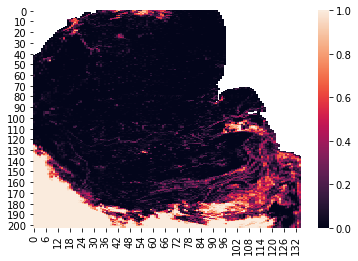

In [52]:
import seaborn as sns
sns.heatmap(pd.DataFrame(data*scale_factor))

In [62]:
scan_time.shape[0]

27405